Este notebook está dedicado al analisis exploratorio de los 3 dataset creados en el notebook anterior llamado **Diabetes Globant Challenge Datasets**. Cada dataset se va a evaluar de forma independiente. Posteriormente, se realizaran comparaciones entre los dataset.

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 60)
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px

## Strack Dataset

In [3]:
Strack_dataset = pd.read_csv('/content/drive/MyDrive/Diabetes Globant Challenge/data/Strack_Diabetes.csv')
Strack_dataset.head(2)

,Unnamed: 0,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,4267,24437208,135,Caucasian,Female,[50-60),2,1,1,8,Cardiology,77,6,33,0,0,0,401,997,560,8,none,none,Steady,No,No,No,No,No,No,Down,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,<30
1,5827,29758806,378,Caucasian,Female,[50-60),3,1,1,2,Surgery-Neuro,49,1,11,0,0,0,722,305,250,3,none,none,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO


Primero vamos a conocer un poco más sobre la columna target **readmitted**

In [10]:
readmitted_freq = Strack_dataset['readmitted'].value_counts().reset_index()
readmitted_freq.columns = ['readmitted', 'Frecuencia']

fig = px.bar(readmitted_freq, x='readmitted', y='Frecuencia', title='Cantidad de readmitted', hover_data= 'Frecuencia')
fig.show()

Con la gráfica anterior observamos que:


*   El 60% de la data tiene como label **NO**
*   El 30% de los pacientes fueron reingresados en un periodo mayor a 30
*   El 10% de los pacientes fueron reingresados en un periodo menor a 30

Strack en su articulo decide unificar los pacientes reingresados. Por efectos de comparación se evaluará y analizará la relación entre los features con el target de la forma original y de la forma propuesta por Strack



### HbA1c

En esta sección vamos a explorar el efecto de la prueba del HbA1c que se ve reflejada en la columna **A1Cresult**. Vamos a comenzar con esta columna ya que es la columna que en trabajos previos se identifica como más importante.

Es importante aclarar que Strack, et al. concluyen que la importancia es realizar el test, no los resultados por lo que exploraremos ambas situaciones

In [27]:
A1C_freq = Strack_dataset.groupby(['A1Cresult'])['readmitted'].value_counts().reset_index()
fig = px.histogram(A1C_freq, x="readmitted", y="count",
                   color='A1Cresult', barmode='group', height=400)
fig.show()

De esta gráfica podemos concluir que al igual que menciona Strack solo se le hace prueba al 18% de los pacientes que ingresan. En los 3 escenarios la cantidad de gente que no le hicieron la prueba es del 80 al 82% para cada caso de readmision.

En los 3 escenarios se observa la misma distribución de los resultados del A1C.
Si los resultados de Strack son correctos, deberiamos encontrar alguna variable adicional que nos permita diferenciar los casos en los que se hizo la prueba y el paciente fue readmitido o no. Para esto vamos a explorar la prueba HbA1c junto con las siguientes columnas:



*   **diabetesMed**: Con el fin de ver si la medicación previa tiene efecto en el resultado del examen
*   **change**: Con el fin de ver si hubo un cambio de medicación cuando los resultados no fueron normales que eviten el reingreso. Tambien se va a mirar si hubo cambio de medicación cuando los resultados fueron normales que llevaran a un reingreso.
*   **diag_1**: Con el fin de ver cual fue el primer diagnostico, según el resultado de la prueba.
*   **medical_specialty**: Con el fin de ver si la especialidad del medico que atiende a la persona tiene influencia
*   **admission_type_id**: Con el fin de ver si hay relación entre el tipo de ingreso, el examen y un posible reingreso
*   **age**: Con el fin de determinar si hay relación entre los resultados del examen y la edad. Las otras variables demograficas como genero y raza serán explorados en un futuro pero por ahora a priori no se consideran.

#### diabetesMed

La prueba de hemoglobina glicosilada (HbA1c) es un examen de sangre para la diabetes tipo 2 y prediabetes. Mide el nivel promedio de glucosa o azúcar en la sangre durante los últimos tres meses. (*https://effectivehealthcare.ahrq.gov/health-topics/prueba-de-hemoglobina-glicosilada-hba1c*)

Basados en la definición de la prueba de HbA1c mi pensamiento inicial es suponer que si la persona se encuentra tomando el medicamento para la diabetes el resultado debería ser normal

In [34]:
diabetesMed_A1c = Strack_dataset.groupby(['diabetesMed'])['A1Cresult'].value_counts().reset_index()
diabetesMed_A1c = diabetesMed_A1c.sort_values(by=['A1Cresult'])
fig = px.histogram(diabetesMed_A1c, x="diabetesMed", y="count",
                   color='A1Cresult', barmode='group')
fig.show()

No vamos a tener en cuenta los 57134 (81.6%) de pacientes que no recibieron la prueba HbA1c.

La prueba HbA1c se considera alta por encima de 7% por lo que cuando hablemos de resultados altos se están sumando los resutlados >8% y >7%.


1.   De los pacientes restantes (12846), la mayoria estaba tomando medicina para la diabetes (82.9% o 10654).
2.   Entre los pacientes que no tomaban medicina la distribución es bastante pareja teniendo 1188 (54.2%) pacientes con resultados altos y 1004 (45.8%) pacientes con resultados normales. Aquí se cumple la lógica que indica que si no están tomando medicamento para la diabetes el examen debe dar resultados altos en la mayoría de los casos, aunque a priori esperaba una diferencia más marcada.
3.   Sorprendentemente, entre los pacientes que toman medicina para la diabetes la mayoría (7916) presenta resultados altos en el examen, en comparación con el 25.7% restante que muestra resultados normales.
4.   A pesar de los resultados presentados en el punto 3. es evidente en la figura que es más probable tener un resultado normal en el examen si se estaba tomando la medicina para la diabetes con anterioridad.

La intuición me indica que los pacientes con resultados altos, especialmente los que están tomando medicación para la diabetes van a tener un reingreso. Vamos a comprobarlo.



In [39]:
diabetesMed_A1c_read = Strack_dataset.groupby(['diabetesMed', 'A1Cresult'])['readmitted'].value_counts().reset_index()
diabetesMed_A1c_read = diabetesMed_A1c_read.sort_values(by=['A1Cresult'])
fig = px.histogram(diabetesMed_A1c_read, x="readmitted", y="count",
                   color='A1Cresult', facet_col='diabetesMed', barmode='group', height=400)
fig.show()

Conclusiones para pacientes que **NO** tomaban medicina para diabetes:


*   El 72% de los pacientes que no toman medicamento y el examen les sale normal no tienen reingreso
*   El 62% de los pacientes que no toman medicamento y el examen les sale alto tienen reingreso. Para este caso hay que revisar cuantos de ellos presentan un cambio en su medicación

Conclusiones para pacientes que **SI** tomaban medicina para diabetes:


*   El 60.5% de los pacientes que si toman medicamento y el examen les sale normal no tienen reingreso
*   El 60.4% de los pacientes que si toman medicamento y el examen les sale alto no tienen reingreso

Curiosidades:


*   Cuando no toman la medicina hay una diferencia porcentual muy importante según los resultados del examen
*   Cuando si toman la medicina no existe diferencia porcentual según los resultados del examen

Próximos paso:

Vamos a explorar la variable change para ver si encontramos algún patrón o algo que nos aclare un poco el panorama en el que estamos.

Preguntas actuales:


1.   Ese 72% que no toma medicina para la diabetes, tienen resutlados normales y no hicieron reingreso habran tenido cambio en su medicamente? Probablemente no (suposición)
2.   El 62% de pacientes que no toma medicamento, tuvo examenes altos pero no tuvo reingreso habrán tenido cambio en su medicamente? Probablemente si (Suposición)
3.   El resto de pacientes que no tomaban medicamento y tuvieron reingreso habran tenido cambio en su medicamento? Probablemente no (Suposición)
4.   Por qué el procentaje de pacientes que si tomaban medicamento no presentaron reingreso sin importar el resultado de los resultados
5.   Qué pasa con todos los que toman medicamento y tienen reingreso?












#### change

Vamos a tratar de responder las preguntas que surgen del análisis anterior

In [43]:
#Dataset de pacientes que No toman medicina, tienen el examen normal y no fueron readmitidos
df1 = Strack_dataset[(Strack_dataset['diabetesMed'] == 'No') &
                     (Strack_dataset['A1Cresult'] == 'Norm') &
                     (Strack_dataset['readmitted'] == 'NO')]
df1['change'].value_counts()

,count
change,
No,723


Confirmamos la suposición y concluimos que **Los pacientes que NO toman medicina y tienen el examen con resultados normales que no fueron readmitidos no tuvieron cambios en su medicación**

In [44]:
#Dataset de pacientes que No toman medicina, tienen el examen normal y si fueron readmitidos
df2 = Strack_dataset[(Strack_dataset['diabetesMed'] == 'No') &
                     (Strack_dataset['A1Cresult'] == 'Norm') &
                     (Strack_dataset['readmitted'] != 'NO')]
df2['change'].value_counts()

,count
change,
No,281


El resultado anterior nos da una conclusión más importante:


*   **Los pacientes que no toman medicamento y tienen resultados normales en el examen NO presentan cambios en su medicación, los que reingresan deben ser por otra variable diferente a la medicación**




In [49]:
#Dataset de pacientes que No toman medicina, tienen el examen alto y no fueron readmitidos
df3 = Strack_dataset[(Strack_dataset['diabetesMed'] == 'No') &
                     (Strack_dataset['A1Cresult'] != 'Norm') &
                     (Strack_dataset['A1Cresult'] != 'none') &
                     (Strack_dataset['readmitted'] == 'NO')]
df3['change'].value_counts()

,count
change,
No,741


In [51]:
#Dataset de pacientes que No toman medicina, tienen el examen alto y si fueron readmitidos
df4 = Strack_dataset[(Strack_dataset['diabetesMed'] == 'No') &
                     (Strack_dataset['A1Cresult'] != 'Norm') &
                     (Strack_dataset['A1Cresult'] != 'none') &
                     (Strack_dataset['readmitted'] != 'NO')]
df4['change'].value_counts()

,count
change,
No,447


Conclusión:

*  **Todos los pacientes que No toman medicina para la diabetes, no presentan cambios en su medicación**

Para este grupo de pacientes, el cambio de medicación no es un factor importante

In [52]:
#Dataset de pacientes que Si toman medicina, tienen el examen normal y no fueron readmitidos
df5 = Strack_dataset[(Strack_dataset['diabetesMed'] == 'Yes') &
                     (Strack_dataset['A1Cresult'] == 'Norm') &
                     (Strack_dataset['readmitted'] == 'NO')]
df5['change'].value_counts()

,count
change,
Ch,945
No,712


In [53]:
#Dataset de pacientes que Si toman medicina, tienen el examen normal y si fueron readmitidos
df6 = Strack_dataset[(Strack_dataset['diabetesMed'] == 'Yes') &
                     (Strack_dataset['A1Cresult'] == 'Norm') &
                     (Strack_dataset['readmitted'] != 'NO')]
df6['change'].value_counts()

,count
change,
Ch,664
No,417


Para el caso donde toman medicina, tienen el examen normal y no fueron readmitidos que sufrieron cambios en su formula es necesario entrar a mirar cual fue el cambio. Ya que lo normal es que con estas condiciones estos pacientes no sufran cambios en su formula.

El resto de casos donde los pacientes Si fueron readmitidos es necesario mirar los cambios que sufrieron y compararlo con lo que vamos a llamar el grupo de control que son los pacientes que si toman medicina, tienen el examen normal y no fueron readmitidos.

In [54]:
#Dataset de pacientes que Si toman medicina, tienen el examen alto y no fueron readmitidos
df7 = Strack_dataset[(Strack_dataset['diabetesMed'] == 'Yes') &
                     (Strack_dataset['A1Cresult'] != 'Norm') &
                     (Strack_dataset['A1Cresult'] != 'none') &
                     (Strack_dataset['readmitted'] == 'NO')]
df7['change'].value_counts()

,count
change,
Ch,3246
No,1540


In [55]:
#Dataset de pacientes que Si toman medicina, tienen el examen alto y si fueron readmitidos
df8 = Strack_dataset[(Strack_dataset['diabetesMed'] == 'Yes') &
                     (Strack_dataset['A1Cresult'] != 'Norm') &
                     (Strack_dataset['A1Cresult'] != 'none') &
                     (Strack_dataset['readmitted'] != 'NO')]
df8['change'].value_counts()

,count
change,
Ch,2227
No,903


La tendencia muestra que 69.1% de las veces que el paciente tiene los examenes altos y toma medicina, le hacen un ajuste en la dosis o le cambian el nombre generico del medicamento. De aquí podemos intuir que la dosis del medicamento o el nombre generico debe influir en si el paciente fue readmitido o no.

El caso donde No fueron readmitidos, si toman medicina, tienen resultados altos pero no presentan cambios en su medicina es necesario comparar dosis contra los pacientes que tienen el examen normal y no fueron readmitidos, ya que es posible que la dosis sea correcta pero todavía no ha tenido efecto.

#### Control group

In [101]:
#Grupo de control
control_group = Strack_dataset[(Strack_dataset['diabetesMed'] == 'Yes') &
                     (Strack_dataset['A1Cresult'] == 'Norm') &
                     (Strack_dataset['readmitted'] == 'NO') &
                     (Strack_dataset['change'] == 'No')]
len(control_group)

712

Vamos a mirar que podemos encontrar en el grupo de control.

En el grupo de control todas las medicinas deben tener 2 posibles valores, **No** o **Steady**. Para encontrar patrones vamos a aplicar dos

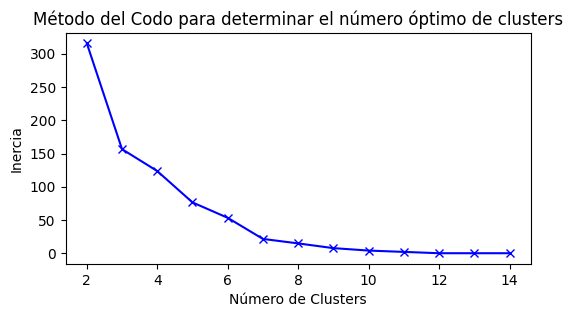

In [102]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

med_control_group = control_group[['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                                   'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
                                   'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                                   'miglitol', 'troglitazone', 'tolazamide', 'examide',
                                   'citoglipton', 'insulin', 'glyburide-metformin',
                                   'glipizide-metformin', 'glimepiride-pioglitazone',
                                   'metformin-rosiglitazone', 'metformin-pioglitazone']]

med_control_group_encoded = med_control_group.apply(LabelEncoder().fit_transform) #0 = No, 1 = Steady

inertia = []
K = range(2, 15)  # Prueba con diferentes números de clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(med_control_group_encoded)
    inertia.append(kmeans.inertia_)

# Graficar la inercia vs. el número de clusters
plt.figure(figsize=(6, 3))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo para determinar el número óptimo de clusters')
plt.show()

In [125]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(med_control_group_encoded)

med_control_group['Cluster'] = clusters
cluster0 = med_control_group[med_control_group['Cluster'] == 0]
cluster1 = med_control_group[med_control_group['Cluster'] == 1]
cluster2 = med_control_group[med_control_group['Cluster'] == 2]

vamos a ver que valores distintos tenemos en cada cluster. Esto para identificar las medicinas que siempre se dan, nunca se dan o pueden variar

In [126]:
for column in cluster0.columns:
  print(f"{column}: {cluster0[column].nunique()}")
print("Tamaño del cluster0:", len(cluster0))
cluster0.head(1)

metformin: 1
repaglinide: 1
nateglinide: 1
chlorpropamide: 1
glimepiride: 1
acetohexamide: 1
glipizide: 1
glyburide: 1
tolbutamide: 1
pioglitazone: 1
rosiglitazone: 1
acarbose: 1
miglitol: 1
troglitazone: 1
tolazamide: 1
examide: 1
citoglipton: 1
insulin: 1
glyburide-metformin: 1
glipizide-metformin: 1
glimepiride-pioglitazone: 1
metformin-rosiglitazone: 1
metformin-pioglitazone: 1
Cluster: 1
Tamaño del cluster0: 120


,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,Cluster
335,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0


Este cluster se caracteriza por tener 120 pacientes los cuales la unica medicina que toman es **metformin**

In [127]:
for column in cluster1.columns:
  print(f"{column}: {cluster1[column].nunique()}")
print("Tamaño del cluster1:", len(cluster1))
cluster1.head(1)

metformin: 1
repaglinide: 1
nateglinide: 1
chlorpropamide: 1
glimepiride: 1
acetohexamide: 1
glipizide: 1
glyburide: 1
tolbutamide: 1
pioglitazone: 1
rosiglitazone: 1
acarbose: 1
miglitol: 1
troglitazone: 1
tolazamide: 1
examide: 1
citoglipton: 1
insulin: 1
glyburide-metformin: 1
glipizide-metformin: 1
glimepiride-pioglitazone: 1
metformin-rosiglitazone: 1
metformin-pioglitazone: 1
Cluster: 1
Tamaño del cluster1: 394


,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,Cluster
32,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,1


Este cluster se caracteriza por tener 394 pacientes los cuales la unica medicina que toman es **insulin**

In [130]:
for column in cluster2.columns:
  print(f"{column}: {cluster2[column].nunique()}")
print("Tamaño del cluster2:", len(cluster2))

metformin: 1
repaglinide: 2
nateglinide: 2
chlorpropamide: 2
glimepiride: 2
acetohexamide: 1
glipizide: 2
glyburide: 2
tolbutamide: 1
pioglitazone: 2
rosiglitazone: 2
acarbose: 2
miglitol: 1
troglitazone: 1
tolazamide: 2
examide: 1
citoglipton: 1
insulin: 1
glyburide-metformin: 1
glipizide-metformin: 1
glimepiride-pioglitazone: 1
metformin-rosiglitazone: 1
metformin-pioglitazone: 1
Cluster: 1
Tamaño del cluster2: 198


Para el cluster 2 con ver la primera fila sabríamos cuales pueden tener Steady o No en cada columna. Despues de esto, estamos interesados en averiguar si hay combinación de medicamentos o si al igual que los cluster anteriores solo se aplican de a uno

In [135]:
def check_multiple_columns_for_value(df, value): #Con esta función vamos a buscar las filas donde la palabra Steady se encuentre en mas de 1 columna
  return (df == value).all(axis=1)

value_to_check = 'Steady'
rows_with_same_value = check_multiple_columns_for_value(cluster2, value_to_check)

# Print the rows that have 'No' in all specified columns.
print(cluster2[rows_with_same_value])

Empty DataFrame
Columns: [metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, citoglipton, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, metformin-pioglitazone, Cluster]
Index: []


In [136]:
cluster2.head(1)

,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,Cluster
24,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,2


El cluster 2 son 198 personas que solo toman un medicamento que puede variar entre:


*   repaglinide
*   nateglinide
*   chlorpropamide
*   glimepiride
*   glipizide
*   glyburide
*   pioglitazone
*   rosiglitazone
*   acarbose
*   tolazamide



Ahora vamos a graficar la cantidad de personas que toma cada medicamento dentro del grupo de control. Recordemos que el grupo de control toma solo 1 medicamento



,Cluster,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone
0,2,198,198,198,198,198,198,198,198,198,198,198,198,198,198,198,198,198,198,198,198,198,198,198


In [153]:
frecuencia_steady = cluster2.apply(lambda col: (col == 'Steady').sum())
frecuencia_steady += cluster1.apply(lambda col: (col == 'Steady').sum())
frecuencia_steady += cluster0.apply(lambda col: (col == 'Steady').sum())
frecuencia_steady_df = frecuencia_steady.reset_index()
frecuencia_steady_df.columns = ['Medicina', 'Cantidad de pacientes']
frecuencia_steady_df = frecuencia_steady_df[frecuencia_steady_df['Cantidad de pacientes'] != 0]
fig = px.bar(frecuencia_steady_df, x='Medicina', y='Cantidad de pacientes',
             title='Cantidad de pacientes vs Medicina')
fig.show()

Conclusiones grupo de control


*   Siempre toman 1 sola medicina
*   La insulina, metformin, glimepiride, glipizide, glyburide, pioglitazone y rosiglitazone van a ser consideradas las medicinas que al tomarse solas deberían dar buenos resultados en el examen y evitar la readmisión

